# BruteForce Searching Demo GunPoint

Demo for unsupervised brute force shaplets searching for anomaly detection 

In [1]:
import sys
sys.path.append('../')

import numpy as np
import random

from tslearn.datasets import CachedDatasets, UCR_UEA_datasets
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance

from src.preprocessing_anomaly import preprocessing_anomaly
from src.SVDD.SVDD import SVDD
from src.util import Scaler
from src.searching.bruteforce_multivariate import Bruteforce_extractor_mv, Candidateset

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.svm import OneClassSVM

import matplotlib.pyplot as plt
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"


## Set up the dataset

### Load the data

Download the data (if needed):

In [2]:
# data_name = "Trace"
# X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset(data_name)
# np.save(f'../demo/data/{data_name}_train', X_train)
# np.save(f'../demo/data/{data_name}_train_labels', y_train)
# np.save(f'../demo/data/{data_name}_test', X_test)
# np.save(f'../demo/data/{data_name}_test_labeles', y_test)

Or load the data from saved numpy arrays:

In [3]:
data_name = "GunPoint"
X_train = np.load(f'../demo/data/{data_name}_train.npy')
y_train = np.load(f'../demo/data/{data_name}_train_labels.npy')
X_test = np.load(f'../demo/data/{data_name}_test.npy')
y_test = np.load(f'../demo/data/{data_name}_test_labeles.npy')

### Preprocessing

#### Get statistics of the entire data:

In [4]:
print(f'Shape of training data: {X_train.shape}')
print(f'Shape of test data: {X_test.shape}')
print(f'The different classes: {set(y_train)}')

# if needed use label encoder to transform the labels from strings to integers
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_test = le.fit_transform(y_test)
# le.classes_

X_total = np.concatenate((X_train, X_test), axis=0)
y_total = np.concatenate((y_train, y_test), axis=0)
print(f'Shape of the total data: {X_total.shape}')

#### check if one class is predominant
obs_perclass = [len(y_total[y_total==i]) for i in set(y_total)]
print(f'Number of total samples in each class: {obs_perclass}')

Shape of training data: (50, 150, 1)
Shape of test data: (150, 150, 1)
The different classes: {1, 2}
Shape of the total data: (200, 150, 1)
Number of total samples in each class: [100, 100]


Use LabelEncoder in case the name of the labels are strings:

In [5]:
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_test = le.fit_transform(y_test)
# print('The positions are the new labels', le.classes_)


Plot one sample per class (first channel in case multivariate):

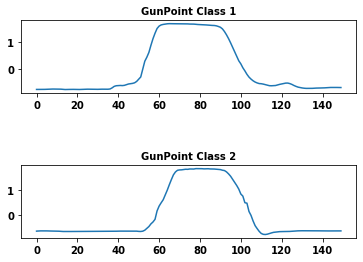

In [6]:
n_class = len(obs_perclass)

fig, ax = plt.subplots(n_class,)

# NOTE: modify if the labels start from 0 or 1
for i in range(n_class):
    ts = X_train[y_train==i+1][0,:,0]
    ax[i].set_title(f'{data_name} Class {i+1}', fontsize=10, fontweight="bold")
    ax[i].plot(ts)
plt.subplots_adjust(hspace=1)
plt.show()

#### Create anomaly detection dataset:

- First the train and test set are merged together
- A proportion "normal_prop" of time series from "normal_class" is selected randomly in the train set
- A proportion "alpha" of the latter set of normal train series is selected randomly from the other classes to represent the anomalies in the train set
- All the other series go in the test set

In [7]:
# Set seed for determinism
np.random.seed(0)

# Set up anomaly detection dataset

normal_class = 1 # choose the normal class
normal_prop = 0.2 # proportion of normal samples that go in train set
alpha = 0.1 # proportion of anomalies wrt normal 
X_train_anomaly, y_train_anomaly, X_test_anomaly, y_test_anomaly = preprocessing_anomaly(X_train, y_train, X_test, y_test, alpha, normal_class=normal_class, normal_prop=normal_prop)


Get statistics of the anomaly detection dataset:

In [8]:
N, Q, n_channels = X_train_anomaly.shape
print(f'{data_name} dataset')
print(f'number train ts is {N}, each of length {Q}')
print(f'They belong to two possible classes: {set(y_train_anomaly)}')
print('number test ts', len(X_test_anomaly))
print('number of normal train series:', len(y_train_anomaly[y_train_anomaly==1]))
print('number of anomalous train series:', len(y_train_anomaly[y_train_anomaly==-1]))
print('number of normal test series:', len(y_test_anomaly[y_test_anomaly==1]))
print('number of anomalous test series:', len(y_test_anomaly[y_test_anomaly==-1]))

GunPoint dataset
number train ts is 22, each of length 150
They belong to two possible classes: {1, -1}
number test ts 178
number of normal train series: 20
number of anomalous train series: 2
number of normal test series: 80
number of anomalous test series: 98


#### Normalize:

Normalize globally:

In [9]:
# normalizer = Normalizer(scaler=StandardScaler())
# X_train_anomaly = normalizer.fit_normalize(X_train_anomaly)
# X_test_anomaly = normalizer.normalize(X_test_anomaly)

Or locally:

In [10]:
scaler = TimeSeriesScalerMinMax()
X_train_anomaly = scaler.fit_transform(X_train_anomaly)
X_test_anomaly = scaler.transform(X_test_anomaly)

#### Plot train and test set

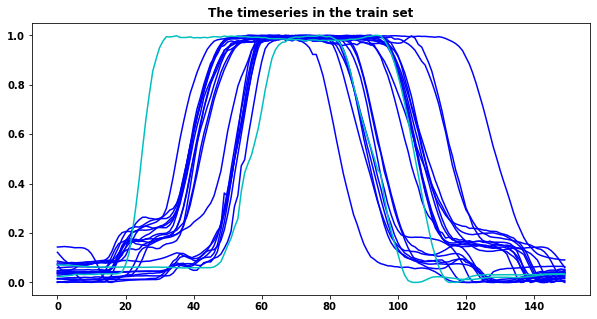

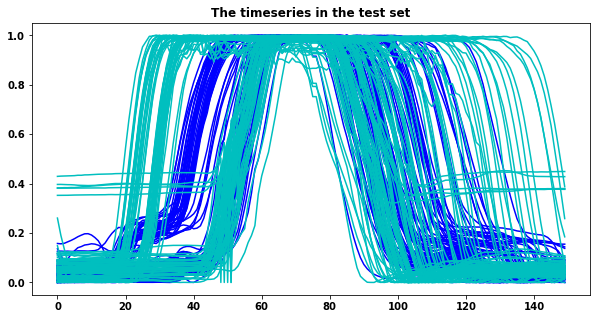

In [11]:
# only first channel in case multivariate
colors = ['r', 'b', 'g', 'y', 'c']

plt.figure(1, figsize=(10, 5))
for ts, label in zip(X_train_anomaly[:,:,0], y_train_anomaly):
    plt.plot(range(len(ts)), ts, c=colors[label%len(colors)])
plt.title('The timeseries in the train set', fontweight="bold")
plt.show()

plt.figure(2, figsize=(10, 5))
for ts, label in zip(X_test_anomaly[:,:,0], y_test_anomaly):
    plt.plot(range(len(ts)), ts, c=colors[label%len(colors)])
plt.title('The timeseries in the test set', fontweight="bold")
plt.show()


## Extract the shapelets from data subsequences

#### Extract GunPoint shapelets with no position filtering since the time series are not aligned

Set up the extractor and hyperparameters:
- K_star: number of shapelets in proportion to length of time series Q
- L_star: length of shapelets in proportion to length of time series
- reverse: bool, whether to take the shapelets with max (True) or min score

In [12]:
extractor = Bruteforce_extractor_mv(train_data=X_train_anomaly, test_data=X_test_anomaly)
K_star = 0.02 # number of shapelets in proportion to length of time series
L_star = 0.2 # length of shapelets in proportion to length of time series
L = round(L_star * Q)

# REVERSE indicates whether the extracted shapelets are the furthest (True) or the nearest (False) to the majority of the time series
reverse = False
corr_threshold = None
pos_boundary = 0

Extract the optimal shapelets:

In [14]:
# shapelets = extractor.extract_shapelets(K_star, L_star, pos_boundary=pos_boundary, corr_threshold=corr_threshold, reverse=reverse)
# S = shapelets.sequences
# print(f'Positions of the shapelets {shapelets.positions}')
# print(f'Scores {shapelets.scores}')

Are going to be extracted 3.000 shapelets of length 30.0000


timeseries: 100%|██████████| 22/22 [14:40<00:00, 40.04s/it]


Candidates are being filtered by a position threshold of 0 time steps
Time for shapelets extraction:
--- 977.271889925003 seconds ---
Positions of the shapelets [ 0 47 89]
Scores [1.67019937e-05 7.31548788e-05 7.77643795e-05]


Check how the top candidates are fitered only by distance:

[1.67019937e-05 1.67939015e-05 1.68147249e-05 1.68605431e-05
 1.73615895e-05 1.73855336e-05 1.73899876e-05 1.74177941e-05
 1.74314508e-05 1.74830225e-05 1.75845992e-05 1.77245126e-05
 1.77873993e-05 1.78101598e-05 1.78705494e-05 1.79204819e-05
 1.80817912e-05 1.80937758e-05 1.81311720e-05 1.81430494e-05
 1.81493599e-05 1.82178342e-05 1.84206475e-05 1.85396593e-05
 1.86157221e-05 1.86217120e-05 1.86278013e-05 1.86784007e-05
 1.87101809e-05 1.88596887e-05 1.89134914e-05 1.90233824e-05
 1.90405191e-05 1.91013687e-05 1.91033347e-05 1.92746643e-05
 1.93630293e-05 1.95265355e-05 1.95361413e-05 1.96391458e-05
 1.96728680e-05 1.98309992e-05 1.98933576e-05 2.01507693e-05
 2.02847614e-05 2.04250274e-05 2.04419697e-05 2.04530659e-05
 2.04622986e-05 2.05678016e-05 2.06089203e-05 2.06627308e-05
 2.07580065e-05 2.07853482e-05 2.08405745e-05 2.08857238e-05
 2.08964846e-05 2.09558714e-05 2.09600524e-05 2.09821420e-05
 2.09849006e-05 2.10020968e-05 2.10246883e-05 2.10687862e-05
 2.11435515e-05 2.117876

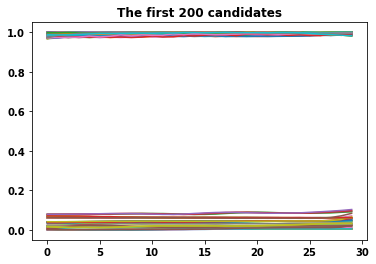

In [25]:
candidates = extractor.candidates
scores = candidates.scores

sequences = candidates.sequences # numpy array
positions = candidates.positions

indexes = scores.argsort()

sequences = sequences[indexes]
positions = positions[indexes]
scores = scores[indexes]
print(scores[0:200])

A = 200

channel = 0
plt.figure()
for i in range(A):
    shap = sequences[i,:,channel]
    plt.plot(shap)
# plt.legend()
plt.title(f'The first {A} candidates', fontweight="bold")
plt.show()

Load the shapelets if are saved in Results:

In [36]:
# np.save(f'../Results/GunPoint/s_reverse={reverse}_L={L}_K={K}', S)

# # in case shapelets are already saved:
# S = np.load(f'../Results/{data_name}/s_class34_reverse={reverse}_pos={pos_boundary}.npy')

# # set manually the shapelets in extractor
# extractor.shapelets = Candidateset()
# extractor.shapelets.sequences = S
K =3
S = np.load(f'../Results/GunPoint/s_reverse={reverse}_L={L}_K={K}.npy')

Plot the shapelets:

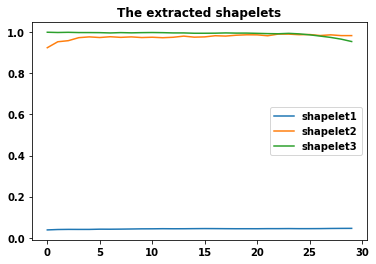

In [37]:
channel = 0
plt.figure()
for i in range(len(S)):
    shap = S[i,:,channel]
    plt.plot(shap, label=f'shapelet{i+1}')
plt.legend()
plt.title('The extracted shapelets', fontweight="bold")
plt.show()

In [38]:
# test the correlation of the shapelets
from src.util import max_corr

corr_matrix = np.zeros((K,K))
for i in range(K):
    for j in range(len(S)):
        corr_matrix[i,j] = max_corr(S[i], S[j])
print(corr_matrix)

[[1.         0.80456929 0.52661054]
 [0.80456929 1.         0.589522  ]
 [0.52661054 0.589522   1.        ]]


#### Shapelets with varying number

In [41]:
C = 1 / (N*alpha)
pos_boundary = 0
corr_threshold = None

for K in [5, 10 ,15, 20, 25]:
    print(f'Number of shapelets: {K}')

    # shapelets = extractor.get_top_candidates(K, pos_boundary, corr_threshold, reverse)
    # S = shapelets.sequences
    # np.save(f'../Results/GunPoint/s_reverse={reverse}_L={L}_K={K}', S)
    S = np.load(f'../Results/GunPoint/s_reverse={reverse}_L={L}_K={K}.npy')

    extractor.shapelets.sequences = S
    # transform both train and test 
    X_train_transform, X_test_transform = extractor.transform()
    svdd = SVDD(C=C, kernel='linear', zero_center=True, tol=1e-6, verbose=False)
    
    # fit the model
    svdd.fit(X_train_transform)

    # BALANCED ACCURACY
    y_test_predict = svdd.predict(X_test_transform)
    test_ba = balanced_accuracy_score(y_test_anomaly, y_test_predict)
    print("Test balanced accuracy:", test_ba)
    
    # AUC
    y_test_scores = svdd.decision_function(X_test_transform)
    auc_test = roc_auc_score(y_test_anomaly, y_test_scores)
    print("Test AUC:", auc_test)
    
    # F1 score
    f1_test = f1_score(y_test_anomaly, y_test_predict)
    print("Test F1 score:", f1_test)
    

Number of shapelets: 5
Test balanced accuracy: 0.3497448979591837
Test AUC: 0.3098214285714285
Test F1 score: 0.3917525773195876
Number of shapelets: 10
Test balanced accuracy: 0.4130102040816327
Test AUC: 0.335204081632653
Test F1 score: 0.5276595744680852
Number of shapelets: 15
Test balanced accuracy: 0.4630102040816326
Test AUC: 0.4239795918367347
Test F1 score: 0.5761316872427984
Number of shapelets: 20
Test balanced accuracy: 0.6017857142857143
Test AUC: 0.6311224489795918
Test F1 score: 0.6262626262626263
Number of shapelets: 25
Test balanced accuracy: 0.5775510204081633
Test AUC: 0.7040816326530613
Test F1 score: 0.64


The results improve slightly with increasing number of shapelets!

Slowness due to the transform operation and distance filtering!

#### Try with longer shapelets

(3, 60, 1)


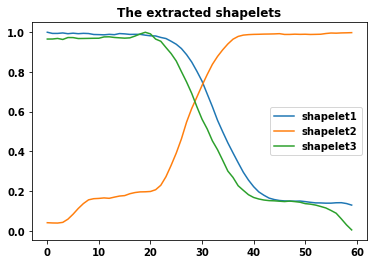

Test balanced accuracy: 0.6966836734693878
Test AUC: 0.9617346938775511
Test F1 score: 0.7255813953488371


In [48]:
extractor = Bruteforce_extractor_mv(train_data=X_train_anomaly, test_data=X_test_anomaly)
K_star = 0.02 # number of shapelets in proportion to length of time series
L_star = 0.4 # length of shapelets in proportion to length of time series
L = round(L_star * Q)
K = round(K_star * Q)

# REVERSE indicates whether the extracted shapelets are the furthest (True) or the nearest (False) to the majority of the time series
reverse = False
corr_threshold = None
pos_boundary = 0
# shapelets = extractor.extract_shapelets(K_star, L_star, pos_boundary=pos_boundary, corr_threshold=corr_threshold, reverse=reverse)
# S = shapelets.sequences
# print(f'Positions of the shapelets {shapelets.positions}')
# print(f'Scores {shapelets.scores}')

S = np.load(f'../Results/GunPoint/s_reverse={reverse}_L={L}_K={K}.npy')

print(S.shape)
channel = 0
plt.figure()
for i in range(len(S)):
    shap = S[i,:,channel]
    plt.plot(shap, label=f'shapelet{i+1}')
plt.legend()
plt.title('The extracted shapelets', fontweight="bold")
plt.show()

extractor.shapelets = Candidateset()
extractor.shapelets.sequences = S

# transform both train and test 
X_train_transform, X_test_transform = extractor.transform()
svdd = SVDD(C=C, kernel='linear', zero_center=True, tol=1e-6, verbose=False)

# fit the model
svdd.fit(X_train_transform)

# BALANCED ACCURACY
y_test_predict = svdd.predict(X_test_transform)
test_ba = balanced_accuracy_score(y_test_anomaly, y_test_predict)
print("Test balanced accuracy:", test_ba)

# AUC
y_test_scores = svdd.decision_function(X_test_transform)
auc_test = roc_auc_score(y_test_anomaly, y_test_scores)
print("Test AUC:", auc_test)

# F1 score
f1_test = f1_score(y_test_anomaly, y_test_predict)
print("Test F1 score:", f1_test)

